In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from util import *
import os
from count_FM_function_v3 import *
from models import * 
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [2]:
def rebin_spike_trials(trials, k):
    """
    trials: list of (T_k, C) spike arrays with 0/1 entries
    k: bin size (in original time steps)
    returns: list of (T_k', C) arrays with spike COUNTS per bin
    """
    rebinned = []
    for x in trials:
        T, C = x.shape
        T_new = T // k
        if T_new == 0:
            continue  # or append empty, depending on your preference
        x_cut = x[:T_new * k]                 # drop tail that does not fit
        x_binned = x_cut.reshape(T_new, k, C).sum(axis=1)
        rebinned.append(x_binned)
    return rebinned

# 1. Read Data

In [3]:
train_loader, val_loader, train_data, val_data, metadata = loader_mc_maze_with_behavior(nForward=1, num_workers=1, batch_size=128)

In [4]:
train_data_rebinned = rebin_spike_trials(train_data, k=200)
trial_idx_use = (np.array(metadata['train']['trial_info']['trial_version']) == 0)
indices = np.where(trial_idx_use)[0]
selected_trials = [train_data_rebinned[i] for i in indices if train_data_rebinned[i].shape[0] > 0]

In [5]:
len(selected_trials)

592

In [6]:
X1_np = np.concatenate(selected_trials, axis=0)

In [7]:
X1_torch = torch.tensor(X1_np)

In [8]:
# rows, cols = X1_np.shape
# plt.imshow(X1_np, aspect=cols / rows, cmap='gray_r');
# plt.colorbar()

In [9]:
del train_loader, val_loader, train_data, val_data, metadata, train_data_rebinned

# Prepare for training

The source distribution is from Poisson(1).\
Here, I fix the sample size source sample, which will make the following 2 endpoints experiements easier.

In [10]:
## This is just to check...
# X1_np = X1_np[:,23:25]
# X1_torch = X1_torch[:,23:25]

In [11]:
# import util
# import importlib
# importlib.reload(util)

In [12]:
N0 = X1_torch.shape[0]
N1 = X1_torch.shape[0]
d = X1_torch.shape[1]

X0_np = np.random.poisson(np.ones((N0, d)))
X0_torch = torch.tensor(X0_np)

In [13]:
# some training settings
batch_size = 1000
num_epochs = 50000
steps_per_epoch = (max(N0, N1) + batch_size - 1) // batch_size

eps_t = 1e-4 # add some eps to avoid rate blow up for t = 1
eps_log = 1e-8 # for Poisson deviance...

lr = 1e-4
loss_mode = 'poisson' # or 'poisson'/ 'l2'

In [14]:
separate_heads = False
use_MLP = True

if not separate_heads:
    if use_MLP:
        net_base = MLP(dim=d, out_dim=2*d, w=128, time_varying=True).to(device)
        net = MLP_rate(net_base)
    else:
        net_base = Adapted_FlatConvUNet(dim=d, out_dim=2*d, time_varying=True).to(device)
        net = Adapted_FlatConvUNet_rate(net_base)    
    
    params = list(net.parameters())
    nets = net
    
if separate_heads:
    if use_MLP:
        net_base_b = MLP(dim=d, out_dim=d, w=128, time_varying=True).to(device)  # births
        net_base_d = MLP(dim=d, out_dim=d, w=128, time_varying=True).to(device)  # deaths
        net_b = MLP_rate(net_base_b)
        net_d = MLP_rate(net_base_d)
    else:
        net_base_b = Adapted_FlatConvUNet(dim=d, out_dim=d, time_varying=True).to(device)  # births
        net_base_d = Adapted_FlatConvUNet(dim=d, out_dim=d, time_varying=True).to(device)  # deaths
        net_b = Adapted_FlatConvUNet_rate(net_base_b)
        net_d = Adapted_FlatConvUNet_rate(net_base_d)
    
    params = list(net_b.parameters()) + list(net_d.parameters())
    nets = [net_b, net_d]
    
optimizer = torch.optim.Adam(params, lr=lr)

# Training

In [29]:
nets, loss = CountFM_train(X1_torch, nets, optimizer, num_epochs,
                           batch_size, device, separate_heads=separate_heads,
                           x0_mode="poisson",  # "uniform", "poisson", or "dataset"
                           eps_t=eps_t, eps_log=eps_log, loss_mode=loss_mode,
                           )

  0%|                                         | 9/50000 [00:00<10:23, 80.14it/s]

[CountFM][epoch 0] loss=87.947525


 20%|███████▍                             | 10012/50000 [02:01<08:12, 81.20it/s]

[CountFM][epoch 10000] loss=85.306862


 40%|██████████████▊                      | 20016/50000 [04:00<06:18, 79.22it/s]

[CountFM][epoch 20000] loss=84.621269


 60%|██████████████████████▏              | 30016/50000 [06:01<04:00, 83.26it/s]

[CountFM][epoch 30000] loss=87.512398


 80%|█████████████████████████████▌       | 40014/50000 [08:01<01:56, 85.68it/s]

[CountFM][epoch 40000] loss=87.572540


100%|█████████████████████████████████████| 50000/50000 [10:00<00:00, 83.27it/s]


In [30]:
loss

tensor(82.0751, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
save_chkpts(nets, "maze_mlp_sep.pt")
# load_chkpts(nets, "maze_mlp_uni.pt")

# Sampling 

In [31]:
np.random.seed(123)
N_new = N1
X0_new_np = np.random.poisson(np.ones((N_new, d)))
X0_new_torch = torch.tensor(X0_new_np)

In [32]:
gc.collect()
torch.cuda.empty_cache()

In [33]:
# free,total = torch.cuda.mem_get_info(); print(f"free={free/1024**3:.2f} GiB / total={total/1024**3:.2f} GiB")
# print(torch.cuda.memory_summary(abbreviated=True))

In [34]:
n_step = 1000
# nets.eval()
with torch.no_grad():
    x1_samples, traj = sample_euler(nets, n_step, X0_new_torch, device, eps_t = 1e-4, eps_log = 1e-8, separate_heads = separate_heads)

# n_step = 100
# nets.eval()
# with torch.no_grad():
#     x1_samples, traj, t_grid = sample_euler_v2(nets, n_step, X0_new_torch, device, eps_t = 1e-4, eps_log = 1e-8, rho = 0.05)

In [35]:
x1_samples_np = x1_samples.detach().cpu().numpy()

# Plots

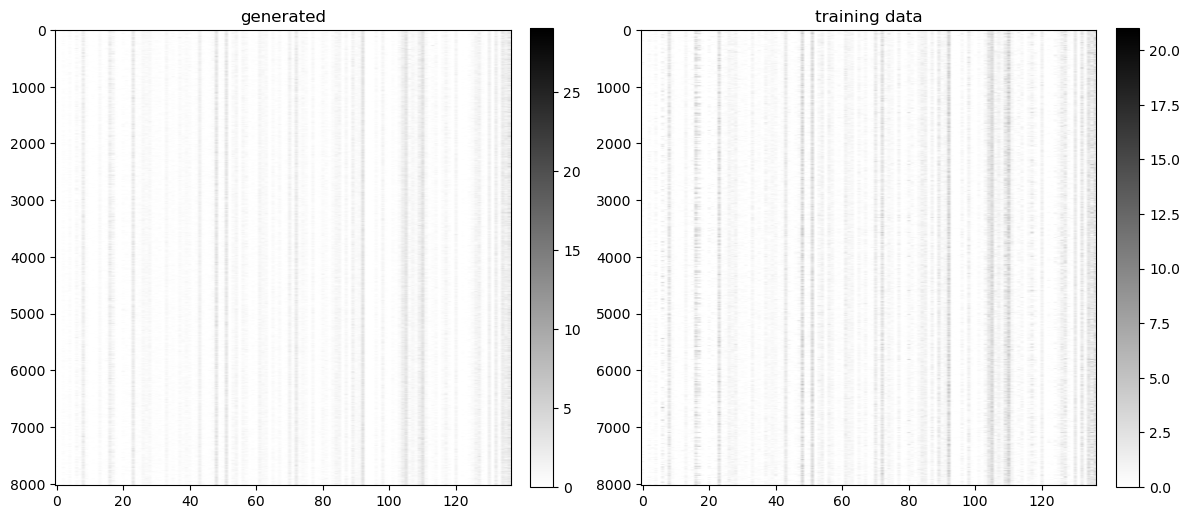

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

rows1, cols1 = x1_samples_np.shape
im1 = axs[0].imshow(x1_samples_np, aspect=cols1 / rows1, cmap='gray_r')
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)  # smaller, aligned
axs[0].set_title('generated')

rows2, cols2 = X1_np.shape
im2 = axs[1].imshow(X1_np, aspect=cols2 / rows2, cmap='gray_r')
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)  # same settings
axs[1].set_title('training data')

plt.tight_layout()
plt.show()

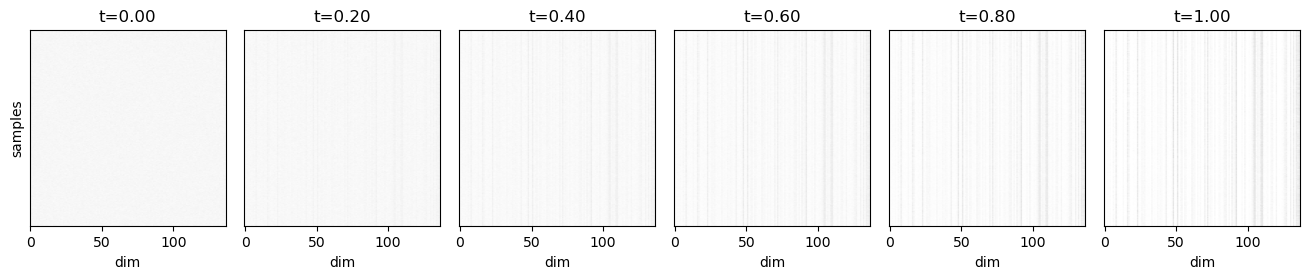

In [37]:
traj_np = traj.cpu().numpy()          # [T, N, d]
T, N, d = traj_np.shape

n_snapshots = 6                       # change if you want more/less
idx_list = np.linspace(0, T-1, n_snapshots, dtype=int)

fig, axs = plt.subplots(1, n_snapshots, figsize=(2.2*n_snapshots, 5), sharey=True)

vmin = traj_np.min()
vmax = traj_np.max()

for ax, idx in zip(axs, idx_list):
    xt = traj_np[idx]                # [N, d] at this time
    rows, cols = xt.shape
    im = ax.imshow(xt,
                   aspect=cols / rows,
                   cmap='gray_r',
                   vmin=vmin,
                   vmax=vmax)
    t_val = idx / (T - 1)
    ax.set_title(f"t={t_val:.2f}")
    ax.set_xlabel('dim')
    ax.set_yticks([])

axs[0].set_ylabel('samples')

# fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Evaluation

## 1D histogram

In [38]:
device = X1_torch.device
real = X1_torch.to(torch.float32)
fake = x1_samples.to(torch.float32)

real_np = real.detach().cpu().numpy()
fake_np = fake.detach().cpu().numpy()

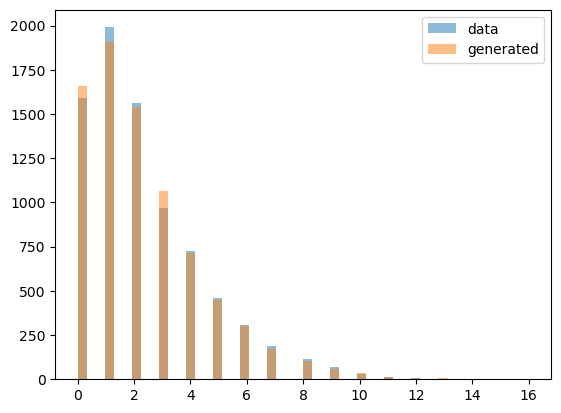

In [39]:
# check distribution of each neuron
neuron_check = 23
plt.hist(real_np[:,neuron_check], 50, alpha = 0.5, label = 'data')
plt.hist(fake_np[:,neuron_check], 50, alpha = 0.5, label = 'generated')
plt.legend()

In [40]:
# unique_real, frequencies_real = np.unique(real_np[:,neuron_check], return_counts=True)
# print(unique_real)
# print(frequencies_real)

# unique_gen, frequencies_gen = np.unique(fake_np[:,neuron_check], return_counts=True)
# print(unique_gen)
# print(frequencies_gen)

## quantitative evaluation

In [41]:
#### 1. Basic marginal checks
mean_r, var_r, zf_r = basic_stats(real)
mean_f, var_f, zf_f = basic_stats(fake)

print("[marginals]")
print(" mean L1 diff      =", (mean_r - mean_f).abs().mean().item())
print(" var  L1 diff      =", (var_r  - var_f ).abs().mean().item())
print(" zero-frac L1 diff =", (zf_r   - zf_f  ).abs().mean().item())


#### 2. Correlation structure
corr_r = corr_mat(real)
corr_f = corr_mat(fake)

corr_fro = (corr_r - corr_f).pow(2).sum().sqrt().item()
print("\n[correlation]")
print(" Frobenius norm ||Corr_real - Corr_fake|| =", corr_fro)


#### 3. Simple MMD (RBF) as FID-analogue
# to keep cost reasonable, subsample if needed
n_sub = min(2000, real.shape[0], fake.shape[0])
idx_r = torch.randperm(real.shape[0], device=device)[:n_sub]
idx_f = torch.randperm(fake.shape[0], device=device)[:n_sub]
mmd_score = mmd_rbf(real[idx_r], fake[idx_f])

print("\n[MMD]")
print(" RBF-MMD^2(real, fake) =", mmd_score)

[marginals]
 mean L1 diff      = 0.01721925474703312
 var  L1 diff      = 0.054751716554164886
 zero-frac L1 diff = 0.008712383918464184

[correlation]
 Frobenius norm ||Corr_real - Corr_fake|| = 2.0298197269439697

[MMD]
 RBF-MMD^2(real, fake) = 0.0001474618911743164


In [28]:
# plt.hist(X0_new_np)